# Iterative Approach for Unet Training 

------

## Overview



The purpose of this learn.ipynb notebook is to investigate whether an image can exhibit a preference for being segmented more effectively using a UNet model trained on polar or cartesian-dominant images.




-----


## File Structure
```
data
└── endoscopic
    ├── cartesian
    │   ├── image
    │   └── label
    └── polar
        ├── image
        └── label
```

Inside of each end folder there are 956 images, named as `0.tif` to `955.tif`
and I believe, for now, the naming of the images are one to one correctly matched, meaning the ``/data/endoscopic/**cartesian**/image/0.tif`` is transformed from `/data/endoscopic/**polar**/image/0.tif`

Instead of putting a seperate set of images aside to be test set, we chose to use k-fold cross validation.

In [ ]:
# Import from files and libraries

In [1]:
from defines import *
from model import *
from data import *
import sys

from numpy import loadtxt
from keras.models import load_model
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import math
import shutil

In [2]:
#run this if your computer has a cuda visible device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
print(PARAM_SYSTEM_TIME)

In [ ]:
# Test code for correct file structure setup

In [ ]:
# Visualize folder tree in current directory
os.system("tree -d")

In [ ]:
#count of files in data directories
os.system("ls " + os.path.join(PARAM_PATH_CARTE,PARAM_IMG_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_CARTE,PARAM_MSK_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_POLAR,PARAM_IMG_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_POLAR,PARAM_MSK_FOLDER) + " | wc -l")


**Expected Output: 
956
956
956
956
**

-----

## Model training test

This part is used to see if we can train a model using the current configuration.

In [ ]:
# Setting Superparameters (temporary) for a test run of model training test

In [4]:
batch_size = 2
PARAM_BETA_TEST_NUM = 0
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
data_gen_args = dict(rotation_range=50,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.35,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
temp_save_dir = os.path.join(os.getcwd(),'temp')
test_gene = trainGenerator(batch_size, os.path.join(PARAM_PATH_TEMP_POLAR,PARAM_SUB_FOLDER_POLAR), PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, data_gen_args)
test_model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 256, 256, 12  0          ['conv2d_18[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  32832       ['up_sampling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 12  0           ['conv2d_1[0][0]',               
                                8)                                'conv2d_19[0][0]']              


2023-09-12 19:56:01.815230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 19:56:01.878504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 19:56:01.880684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 19:56:01.883346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_20[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 256, 256, 2)  1154        ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 1)  3           ['conv2d_22[0][0]']              
          

### Expected output
<details>
    <summary><b><font color="green">Click here to expand</font></b></summary>
    <code>
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_120 (Conv2D)            (None, 256, 256, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_121 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_120[0][0]']             
                                )                                                                 
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 128, 128, 64  0          ['conv2d_121[0][0]']             
 )                              )                                                                 
                                                                                                  
 conv2d_122 (Conv2D)            (None, 128, 128, 12  73856       ['max_pooling2d_20[0][0]']       
                                8)                                                                
                                                                                                  
 conv2d_123 (Conv2D)            (None, 128, 128, 12  147584      ['conv2d_122[0][0]']             
                                8)                                                                
                                                                                                  
 max_pooling2d_21 (MaxPooling2D  (None, 64, 64, 128)  0          ['conv2d_123[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_124 (Conv2D)            (None, 64, 64, 256)  295168      ['max_pooling2d_21[0][0]']       
                                                                                                  
 conv2d_125 (Conv2D)            (None, 64, 64, 256)  590080      ['conv2d_124[0][0]']             
                                                                                                  
 max_pooling2d_22 (MaxPooling2D  (None, 32, 32, 256)  0          ['conv2d_125[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_126 (Conv2D)            (None, 32, 32, 512)  1180160     ['max_pooling2d_22[0][0]']       
                                                                                                  
 conv2d_127 (Conv2D)            (None, 32, 32, 512)  2359808     ['conv2d_126[0][0]']             
                                                                                                  
 dropout_10 (Dropout)           (None, 32, 32, 512)  0           ['conv2d_127[0][0]']             
                                                                                                  
 max_pooling2d_23 (MaxPooling2D  (None, 16, 16, 512)  0          ['dropout_10[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_128 (Conv2D)            (None, 16, 16, 1024  4719616     ['max_pooling2d_23[0][0]']       
                                )                                                                 
                                                                                                  
 conv2d_129 (Conv2D)            (None, 16, 16, 1024  9438208     ['conv2d_128[0][0]']             
                                )                                                                 
                                                                                                  
 dropout_11 (Dropout)           (None, 16, 16, 1024  0           ['conv2d_129[0][0]']             
                                )                                                                 
                                                                                                  
 up_sampling2d_20 (UpSampling2D  (None, 32, 32, 1024  0          ['dropout_11[0][0]']             
 )                              )                                                                 
                                                                                                  
 conv2d_130 (Conv2D)            (None, 32, 32, 512)  2097664     ['up_sampling2d_20[0][0]']       
                                                                                                  
 concatenate_20 (Concatenate)   (None, 32, 32, 1024  0           ['dropout_10[0][0]',             
                                )                                 'conv2d_130[0][0]']             
                                                                                                  
 conv2d_131 (Conv2D)            (None, 32, 32, 512)  4719104     ['concatenate_20[0][0]']         
                                                                                                  
 conv2d_132 (Conv2D)            (None, 32, 32, 512)  2359808     ['conv2d_131[0][0]']             
                                                                                                  
 up_sampling2d_21 (UpSampling2D  (None, 64, 64, 512)  0          ['conv2d_132[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 64, 64, 256)  524544      ['up_sampling2d_21[0][0]']       
                                                                                                  
 concatenate_21 (Concatenate)   (None, 64, 64, 512)  0           ['conv2d_125[0][0]',             
                                                                  'conv2d_133[0][0]']             
                                                                                                  
 conv2d_134 (Conv2D)            (None, 64, 64, 256)  1179904     ['concatenate_21[0][0]']         
                                                                                                  
 conv2d_135 (Conv2D)            (None, 64, 64, 256)  590080      ['conv2d_134[0][0]']             
                                                                                                  
 up_sampling2d_22 (UpSampling2D  (None, 128, 128, 25  0          ['conv2d_135[0][0]']             
 )                              6)                                                                
                                                                                                  
 conv2d_136 (Conv2D)            (None, 128, 128, 12  131200      ['up_sampling2d_22[0][0]']       
                                8)                                                                
                                                                                                  
 concatenate_22 (Concatenate)   (None, 128, 128, 25  0           ['conv2d_123[0][0]',             
                                6)                                'conv2d_136[0][0]']             
                                                                                                  
 conv2d_137 (Conv2D)            (None, 128, 128, 12  295040      ['concatenate_22[0][0]']         
                                8)                                                                
                                                                                                  
 conv2d_138 (Conv2D)            (None, 128, 128, 12  147584      ['conv2d_137[0][0]']             
                                8)                                                                
                                                                                                  
 up_sampling2d_23 (UpSampling2D  (None, 256, 256, 12  0          ['conv2d_138[0][0]']             
 )                              8)                                                                
                                                                                                  
 conv2d_139 (Conv2D)            (None, 256, 256, 64  32832       ['up_sampling2d_23[0][0]']       
                                )                                                                 
                                                                                                  
 concatenate_23 (Concatenate)   (None, 256, 256, 12  0           ['conv2d_121[0][0]',             
                                8)                                'conv2d_139[0][0]']             
                                                                                                  
 conv2d_140 (Conv2D)            (None, 256, 256, 64  73792       ['concatenate_23[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_141 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_140[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_142 (Conv2D)            (None, 256, 256, 9)  5193        ['conv2d_141[0][0]']             
                                                                                                  
 conv2d_143 (Conv2D)            (None, 256, 256, 3)  30          ['conv2d_142[0][0]']             
                                                                                                  
==================================================================================================
Total params: 31,036,903
Trainable params: 31,036,903
Non-trainable params: 0
</code>
</details>    

In [5]:
model_checkpoint = ModelCheckpoint('unet_endoscopic.hdf5', monitor = 'loss', verbose=1, save_best_only=True)

In [6]:
test_run = test_model.fit(test_gene, verbose = 1, steps_per_epoch = 500, epochs = 20, callbacks = [model_checkpoint])

Found 478 images belonging to 1 classes.
Found 478 images belonging to 1 classes.
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.ex

2023-09-12 19:56:13.424168: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-09-12 19:56:14.275536: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


500/500 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.5857 - dice_coef_loss: 0.7879
Epoch 1: loss improved from inf to 0.78786, saving model to unet_endoscopic.hdf5
500/500 [==============================] - 71s 130ms/step - loss: 0.7879 - accuracy: 0.5857 - dice_coef_loss: 0.7879
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.8565 - dice_coef_loss: 0.7040
Epoch 2: loss improved from 0.78786 to 0.70396, saving model to unet_endoscopic.hdf5
500/500 [==============================] - 65s 131ms/step - loss: 0.7040 - accuracy: 0.8565 - dice_coef_loss: 0.7040
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.8733 - dice_coef_loss: 0.6754
Epoch 3: loss improved from 0.70396 to 0.67540, saving model to unet_endoscopic.hdf5
500/500 [==============================] - 65s 131ms/step - loss: 0.6754 - accuracy: 0.8733 - dice_coef_loss: 0.6754
Epoch 4/20
500/500 [==========================

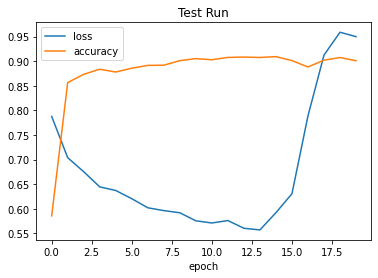

In [7]:
#print(test_run.history.keys())
plt.plot(test_run.history['loss'])
plt.plot(test_run.history['accuracy'])
plt.title('Test Run')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [ ]:
PARAM_PATH_TEST = './test'
image_name = '29.tif'
img = io.imread(os.path.join(PARAM_PATH_TEST,image_name),as_gray = False)
img = trans.resize(img,[256,256])
img = np.reshape(img,(1,)+img.shape)

results = test_model.predict(img,1,verbose=1)
#saveResult(Path,results)
img = results[0,:,:]
print(results.shape)
io.imsave(os.path.join(PARAM_PATH_TEST,"result.png"),img)

----

## File Relocation

In the following block, the code loads in one analysis file from previous research. 

### #File name postfix
_C_ is the dice scores of the predictions generated by Unet C: this Unet C is trained using all 7404 images, in their cartesian form. The raw image was directly input into the Unet and the prediction was generated.

_P_ is the dice scores of the predictions generated by Unet P: this Unet P is trained using all 7404 images but in their polar form. The raw images were transformed, and then input for prediction. The prediction is in polar space.

_P2C_ is the dice scores of the predictions generated by the same Unet P as mentioned above, but the dice score is generated by transforming the prediction back to cartesian, and compared to their original label.

In [ ]:
import numpy as np

#file_name = 'analysis_dice_back_Test_C.npy'
file_name = 'analysis_dice_back_Test_P.npy'
#file_name = 'analysis_dice_back_Test_P2C.npy'
np_file = os.path.join(PARAM_PATH_SCORES, file_name)
#load npy file
img_score = np.load(np_file)
#sort scores in descending order and store index
sorted_score = np.flip(np.argsort(img_score))
#print(sorted_score)


In [ ]:
sorted_score = pd.DataFrame(sorted_score)

#fetch top polar dominant and non-polar dominant image
num_polar = round(len(sorted_score)/2)
num_cartesian = len(sorted_score) - num_polar
dfPolar = sorted_score.head(num_polar)
dfCartesian = sorted_score.tail(num_cartesian)
print("Polar: \n", dfPolar)
print("Cartesian: \n", dfCartesian)

In [ ]:
#create new directories for polar dominant images and cartesian dominant images based on sorted dice scores

if os.path.exists(PARAM_PATH_TEMP_POLAR):#
    shutil.rmtree(PARAM_PATH_TEMP_POLAR)
os.makedirs(PARAM_PATH_TEMP_POLAR)
this_folder = os.path.join(PARAM_PATH_TEMP_POLAR,PARAM_SUB_FOLDER_POLAR)#Creation of subfolder
os.makedirs(os.path.join(this_folder,PARAM_IMG_FOLDER))
os.makedirs(os.path.join(this_folder,PARAM_MSK_FOLDER))
this_folder = os.path.join(PARAM_PATH_TEMP_POLAR,PARAM_SUB_FOLDER_CARTE)
os.makedirs(os.path.join(this_folder,PARAM_IMG_FOLDER))
os.makedirs(os.path.join(this_folder,PARAM_MSK_FOLDER))

if os.path.exists(PARAM_PATH_TEMP_CARTE):
    shutil.rmtree(PARAM_PATH_TEMP_CARTE)
os.makedirs(PARAM_PATH_TEMP_CARTE)
this_folder = os.path.join(PARAM_PATH_TEMP_CARTE,PARAM_SUB_FOLDER_POLAR)#Creation of subfolder
os.makedirs(os.path.join(this_folder,PARAM_IMG_FOLDER))
os.makedirs(os.path.join(this_folder,PARAM_MSK_FOLDER))
this_folder = os.path.join(PARAM_PATH_TEMP_CARTE,PARAM_SUB_FOLDER_CARTE)
os.makedirs(os.path.join(this_folder,PARAM_IMG_FOLDER))
os.makedirs(os.path.join(this_folder,PARAM_MSK_FOLDER))

for img in dfPolar[0]:
    img_name = str(img) + ".tif"
    #Copy polar img and mask in
    this_folder = os.path.join(PARAM_PATH_TEMP_POLAR,PARAM_SUB_FOLDER_POLAR)
    src = os.path.join(PARAM_PATH_POLAR, PARAM_IMG_FOLDER, img_name)
    shutil.copy2(src, os.path.join(this_folder,PARAM_IMG_FOLDER))
    src = os.path.join(PARAM_PATH_POLAR, PARAM_MSK_FOLDER, img_name)
    shutil.copy2(src, os.path.join(this_folder,PARAM_MSK_FOLDER))
    #Copy cartesian img and mask in
    this_folder = os.path.join(PARAM_PATH_TEMP_POLAR,PARAM_SUB_FOLDER_CARTE)
    src = os.path.join(PARAM_PATH_CARTE, PARAM_IMG_FOLDER, img_name)
    shutil.copy2(src, os.path.join(this_folder,PARAM_IMG_FOLDER))
    src = os.path.join(PARAM_PATH_CARTE, PARAM_MSK_FOLDER, img_name)
    shutil.copy2(src, os.path.join(this_folder,PARAM_MSK_FOLDER))
    
for img in dfCartesian[0]:
    img_name = str(img) + ".tif"
    #Copy polar img and mask in
    this_folder = os.path.join(PARAM_PATH_TEMP_CARTE,PARAM_SUB_FOLDER_POLAR)
    src = os.path.join(PARAM_PATH_POLAR, PARAM_IMG_FOLDER, img_name)
    shutil.copy2(src, os.path.join(this_folder,PARAM_IMG_FOLDER))
    src = os.path.join(PARAM_PATH_POLAR, PARAM_MSK_FOLDER, img_name)
    shutil.copy2(src, os.path.join(this_folder,PARAM_MSK_FOLDER))
    #Copy cartesian img and mask in    
    this_folder = os.path.join(PARAM_PATH_TEMP_CARTE,PARAM_SUB_FOLDER_CARTE)
    src = os.path.join(PARAM_PATH_CARTE, PARAM_IMG_FOLDER, img_name)
    shutil.copy2(src, os.path.join(this_folder,PARAM_IMG_FOLDER))
    src = os.path.join(PARAM_PATH_CARTE, PARAM_MSK_FOLDER, img_name)
    shutil.copy2(src, os.path.join(this_folder,PARAM_MSK_FOLDER))

In [ ]:
#K fold Validation (obtain training & testing sets)
from sklearn.model_selection import KFold

kfold = KFold(n_splits=PARAM_SPLIT_NUM)
for train_index,test_index in kfold.split(dfPolar):
    polar_train,polar_test=dfPolar.iloc[train_index, :],dfPolar.iloc[test_index, :]
    cartesian_train,cartesian_test=dfCartesian.iloc[train_index, :],dfCartesian.iloc[test_index, :]
    print("polar train: ", polar_train, "polar test: ", polar_test)
    print("cartesian train" , cartesian_train, "cartesian test", cartesian_test)

-----

# Legacy Code Below
### written by Wenfan

In [ ]:
from defines import *
from model import *
from data import *
import sys

from numpy import loadtxt
from keras.models import load_model
from PIL import Image

import glob
import os 
import math
import shutil

In [ ]:
path = 'data_jupyter'# main folder path

D = 'all_images'
L = 'all_labels'

D_P_im = 'polar_im'
D_C_im = 'car_im'
D_P = 'polar_l'
D_C = 'car_l'

prev_number_of_D_P = -1
prev_number_of_D_C = -1

diff = math.inf

model_P = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM])
model_C = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM])

In [ ]:
#fill in the weights here
model_P.load_weights() 
model_C.load_weights() 

In [ ]:
count = 0

#change file name of D, L
for count, filename in enumerate(os.listdir(path+'/'+D)): 
    dst = str(count) + ".png"
    src = path+'/'+D+'/'+filename
    dst = path+'/'+D+'/'+dst

    os.rename(src, dst) 
    
for count, filename in enumerate(os.listdir(path+'/'+L)): 
    dst = str(count) + ".tif"
    src = path+'/'+L+'/'+filename
    dst = path+'/'+L+'/'+dst

    os.rename(src, dst) 

In [ ]:
def dscore(im, im_name):
    label = Image.open(os.path.join(L, im_name))
    
    pixelIm = im.load()
    pixelLabel = label.load()
    
    upper = 0
    lower = im.size[0] * im.size[1]
    
    for i in range(im.size[0]):
        for j in range(im.size[1]):
            if pixelIm[i,j] == pixelLabel[i,j]:
                upper = upper + 1
            
    upper = upper * 2
    
    return upper / lower
                

In [ ]:
while (diff > 0): 
    #load model
    #if count > 0:
    #    model_P.load_weights('model_P_weights_' + (count - 1))
    #    model_C.load_weights('model_C_weights_' + (count - 1))
    
    count = count + 1
    
    testGene_P, testGene_C = testGenerator(path,D,L)
    
    #perdict
    results_P = model_P.predict(testGene_P, PARAM_N_TESTS, verbose=1)
    results_C = model_C.predict(testGene_C, PARAM_N_TESTS, verbose=1)

    np.save(PARAM_PATH_TEST_NPY_P, results_P)
    saveResult(PARAM_PATH_TEST_RESULTS_P, results_P)
    np.save(PARAM_PATH_TEST_NPY_C, results_C)
    saveResult(PARAM_PATH_TEST_RESULTS_C, results_C)
    
    mergeIm(path, D, L, PARAM_PATH_TEST_RESULTS_P, path+'/'+D_P)
    mergeIm(path, D, L, PARAM_PATH_TEST_RESULTS_C, path+'/'+D_C)
    
    #change file name of D_P, D_C
    for count, filename in enumerate(os.listdir(path+'/'+D_P)): 
        dst = str(count) + ".tif"
        src = path+'/'+D_P+'/'+filenaLme
        dst = path+'/'+D_P+'/'+dst

        os.rename(src, dst) 
  
    for count, filename in enumerate(os.listdir(path+'/'+D_C)): 
        dst = str(count) + ".tif"
        src = path+'/'+D_C+'/'+filename
        dst = path+'/'+D_C+'/'+dst

        os.rename(src, dst) 
    
    #find the better one (based on L) and modify D_P, D_P_im, D_C, D_C_im
    for file in os.listdir(D):
        im_P = Image.open(path+'/'+D_P+'/'+file)
        im_C = Image.open(path+'/'+D_C+'/'+file)
        
        if dscore(im_P, file) > dscore(im_C, file):
            shutil.copyfile(path+'/'+D+'/'+file, path+'/'+D_P_im+'/'+file)
            os.remove(path+'/'+D_C+'/'+file)
        else:
            shutil.copyfile(path+'/'+D+'/'+file, path+'/'+D_C_im+'/'+file)
            os.remove(path+'/'+D_P+'/'+file)
            
    number_of_D_P = len(glob.glob(D_P))
    number_of_D_C = len(glob.glob(D_C))

    # file numbers difference
    diff = Math.abs(prev_number_of_D_P - number_of_D_P + prev_number_of_D_C - number_of_D_C) / 2
    
    prev_number_of_D_P = number_of_D_P
    prev_number_of_D_C = number_of_D_P
    
    #train model_P only on D_P, model_C only on D_C
    myGene_P = trainGenerator(PARAM_BATCHES, 
                            path, 
                            D_P, 
                            D_P_im, 
                            PARAM_DATA_ARGS, 
                            save_to_dir = PARAM_AUG_FOLDER_P)
    
    myGene_C = trainGenerator(PARAM_BATCHES, 
                            path, 
                            D_C, 
                            D_C_im, 
                            PARAM_DATA_ARGS, 
                            save_to_dir = PARAM_AUG_FOLDER_C)
    
    model_checkpoint_P = ModelCheckpoint( PARAM_SAVED_MODEL, 
                                         monitor = PARAM_METRICS, 
                                         verbose = 1, 
                                         save_best_only = PARAM_SAVE_BEST_ONLY)
    
    model_P.fit_generator(myGene_P,
                        steps_per_epoch = PARAM_EPOCH_STEPS,
                        epochs = PARAM_N_EPOCHS,
                        callbacks = [model_checkpoint])
    model_C.fit_generator(myGene_C,
                        steps_per_epoch = PARAM_EPOCH_STEPS,
                        epochs = PARAM_N_EPOCHS,
                        callbacks = [model_checkpoint])
    
    model_P.save_weights('model_P_weights_' + count)
    model_C.save_weights('model_C_weights_' + count)
    
    shutil.rmtree(path+'/'+D_P)
    shutil.rmtree(path+'/'+D_C)
    shutil.rmtree(path+'/'+D_P_im)
    shutil.rmtree(path+'/'+D_C_im)
    

save_model(model_P, 'model_P.h5')
save_model(model_C, 'model_C.h5')
    